### CARGAR LIBRERIAS Y DATASETS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np    
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

def saca_metricas(y_real, y_pred): 
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    print('- AUC: {roc_auc}')
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

In [2]:
train = pd.read_csv("./train_ctrUa4K.csv")
test = pd.read_csv("./test_lAUu6dG.csv")

### Pre-procesado y limpieza de datos

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [5]:
# Separo variable objetivo del resto para trabajar sin ella
loan_status = train[["Loan_ID", "Loan_Status"]]
train.drop("Loan_Status", axis = 1, inplace = True)
data = train.append(test)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 99.6+ KB


In [7]:
# separo nombres de columnas categóricas de columnas numéricas, para echarles
# un vistazo en las siguientes tablas
data_cat = data.select_dtypes(include = "object").columns
data_num = data.select_dtypes(exclude = "object").columns

In [8]:
data[data_cat].describe()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
count,981,957,978,956,981,926,981
unique,981,2,2,4,2,2,3
top,LP002554,Male,Yes,0,Graduate,No,Semiurban
freq,1,775,631,545,763,807,349


In [9]:
data[data_num].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [10]:
# Echando un vistazo a la última tabla, se puede detectar un posible
# outlier en el valor máximo, aunque lo estudiaré más adelante.

### Tratamiento de nulos

In [11]:
data.isnull().sum()

Loan_ID               0
Gender               24
Married               3
Dependents           25
Education             0
Self_Employed        55
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           27
Loan_Amount_Term     20
Credit_History       79
Property_Area         0
dtype: int64

In [12]:
# Gender: reemplazaremos los valores nulos con Male, grupo mayoritario.
data["Gender"] = data["Gender"].fillna("Male")

In [13]:
# Married: al ser variable binaria, reemplazo por el grupo mayoritario.
data["Married"] = data["Married"].fillna("Yes")

In [14]:
# Dependents: al ser variable binaria, reemplazo por el grupo mayoritario.
data["Dependents"] = data["Dependents"].fillna("0")

In [15]:
# Self_Employed: al ser variable binaria, reemplazo por el grupo mayoritario.
data["Self_Employed"] = data["Self_Employed"].fillna("No")

In [16]:
# LoanAmount: reemplazo Na´s por media de la variable
data["LoanAmount"] = data["LoanAmount"].fillna(data["LoanAmount"].mean())

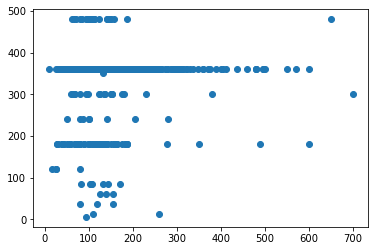

In [17]:
# Loan_Amount_Term: antes de proceder, echo un vistazo a la siguiente información.
plt.scatter(data["LoanAmount"], data["Loan_Amount_Term"])

(array([  6.,  10.,   4.,  66.,   8.,   0.,  20., 824.,   0.,  23.]),
 array([  6. ,  53.4, 100.8, 148.2, 195.6, 243. , 290.4, 337.8, 385.2,
        432.6, 480. ]),
 <BarContainer object of 10 artists>)

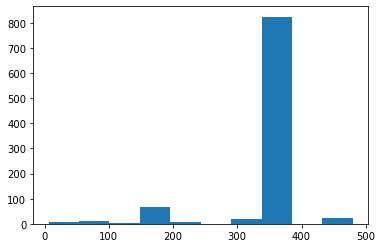

In [18]:
plt.hist(data["Loan_Amount_Term"])

In [19]:
data["Loan_Amount_Term"].value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

In [20]:
corr_df = data[["LoanAmount", "Loan_Amount_Term"]]
corr_df.corr()

,LoanAmount,Loan_Amount_Term
LoanAmount,1.00000,0.05501
Loan_Amount_Term,0.05501,1.00000


In [21]:
# Viendo los gráficos y la tabla de correlación, no se detecta relación
# entre cantidad y tiempo de préstamos, por lo que usaré la moda para
# sustituir los valores Na.

In [22]:
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].mode()[0])

In [23]:
data["Credit_History"].value_counts()

1.0    754
0.0    148
Name: Credit_History, dtype: int64

In [24]:
# Credit_History: al ser variable binaria, reemplazo por el grupo mayoritario.
data["Credit_History"] = data["Credit_History"].fillna(1)

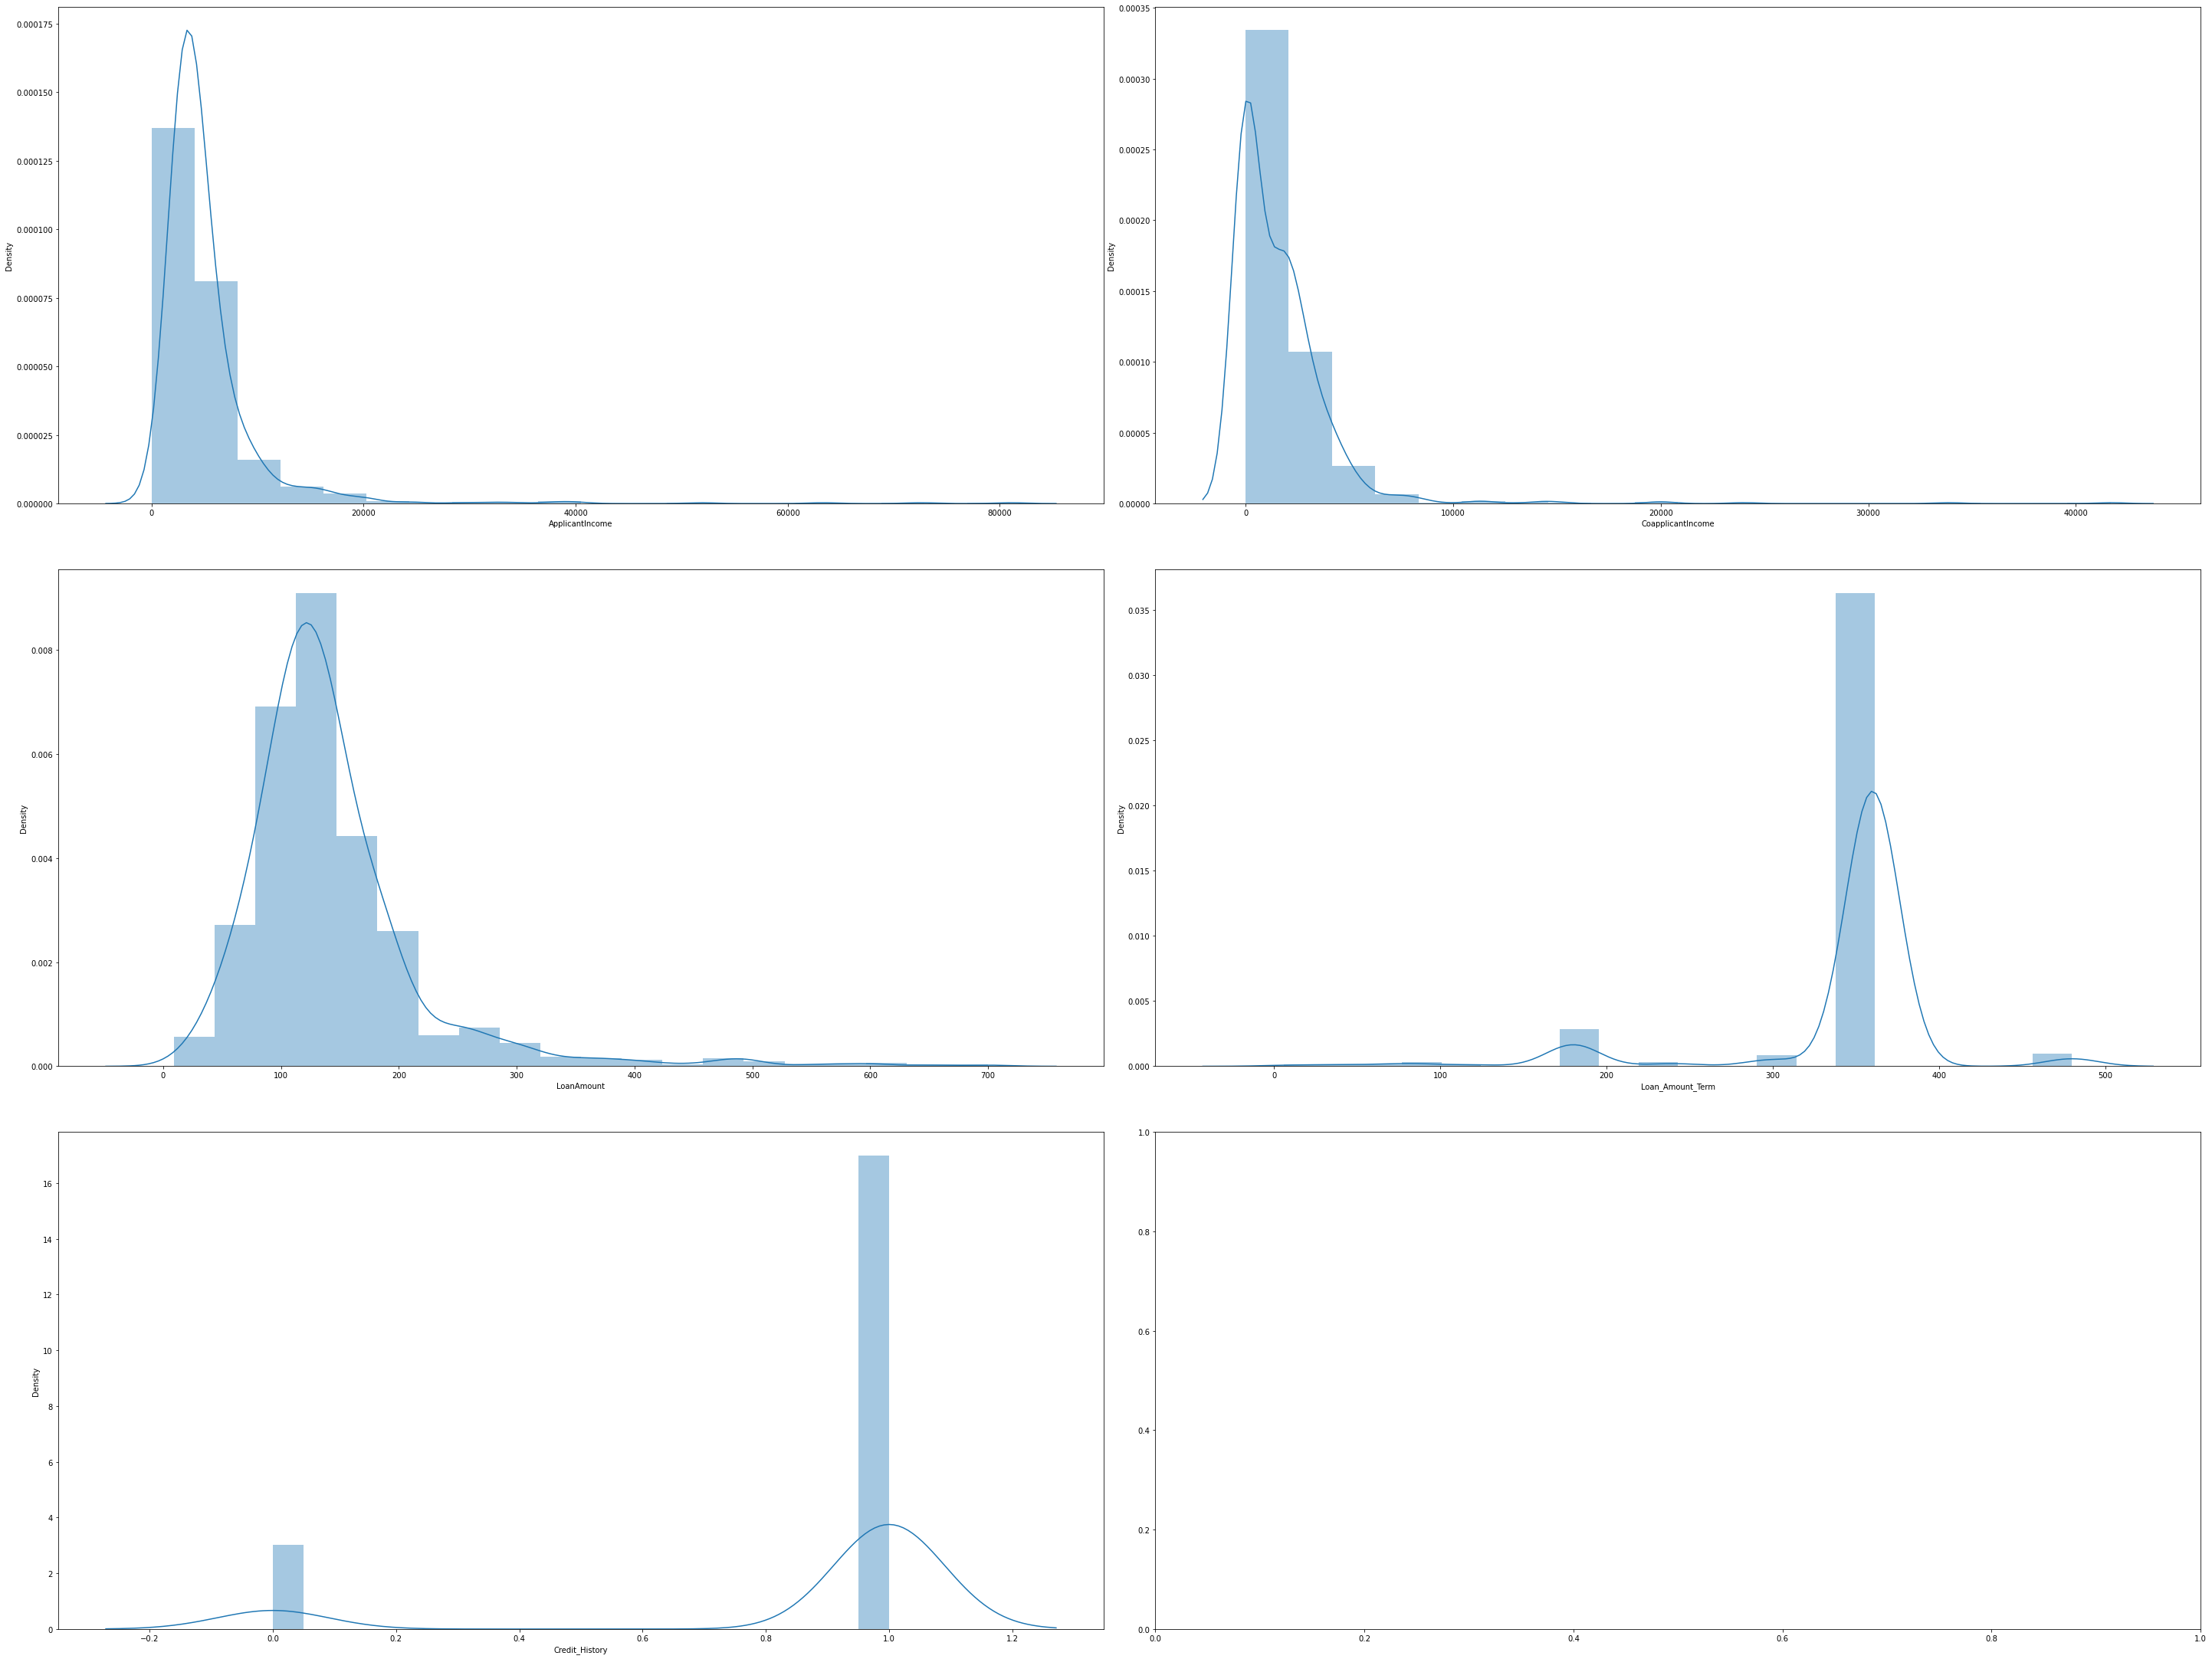

In [25]:
#Variables numéricas
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(40, 30))
axs = axs.flatten() # 

index = 0
for k,v in data[data_num].items(): 
    if  (k == 'Loan_Status'):
        sns.countplot(v, ax=axs[index])
    else:
        sns.distplot(v, bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

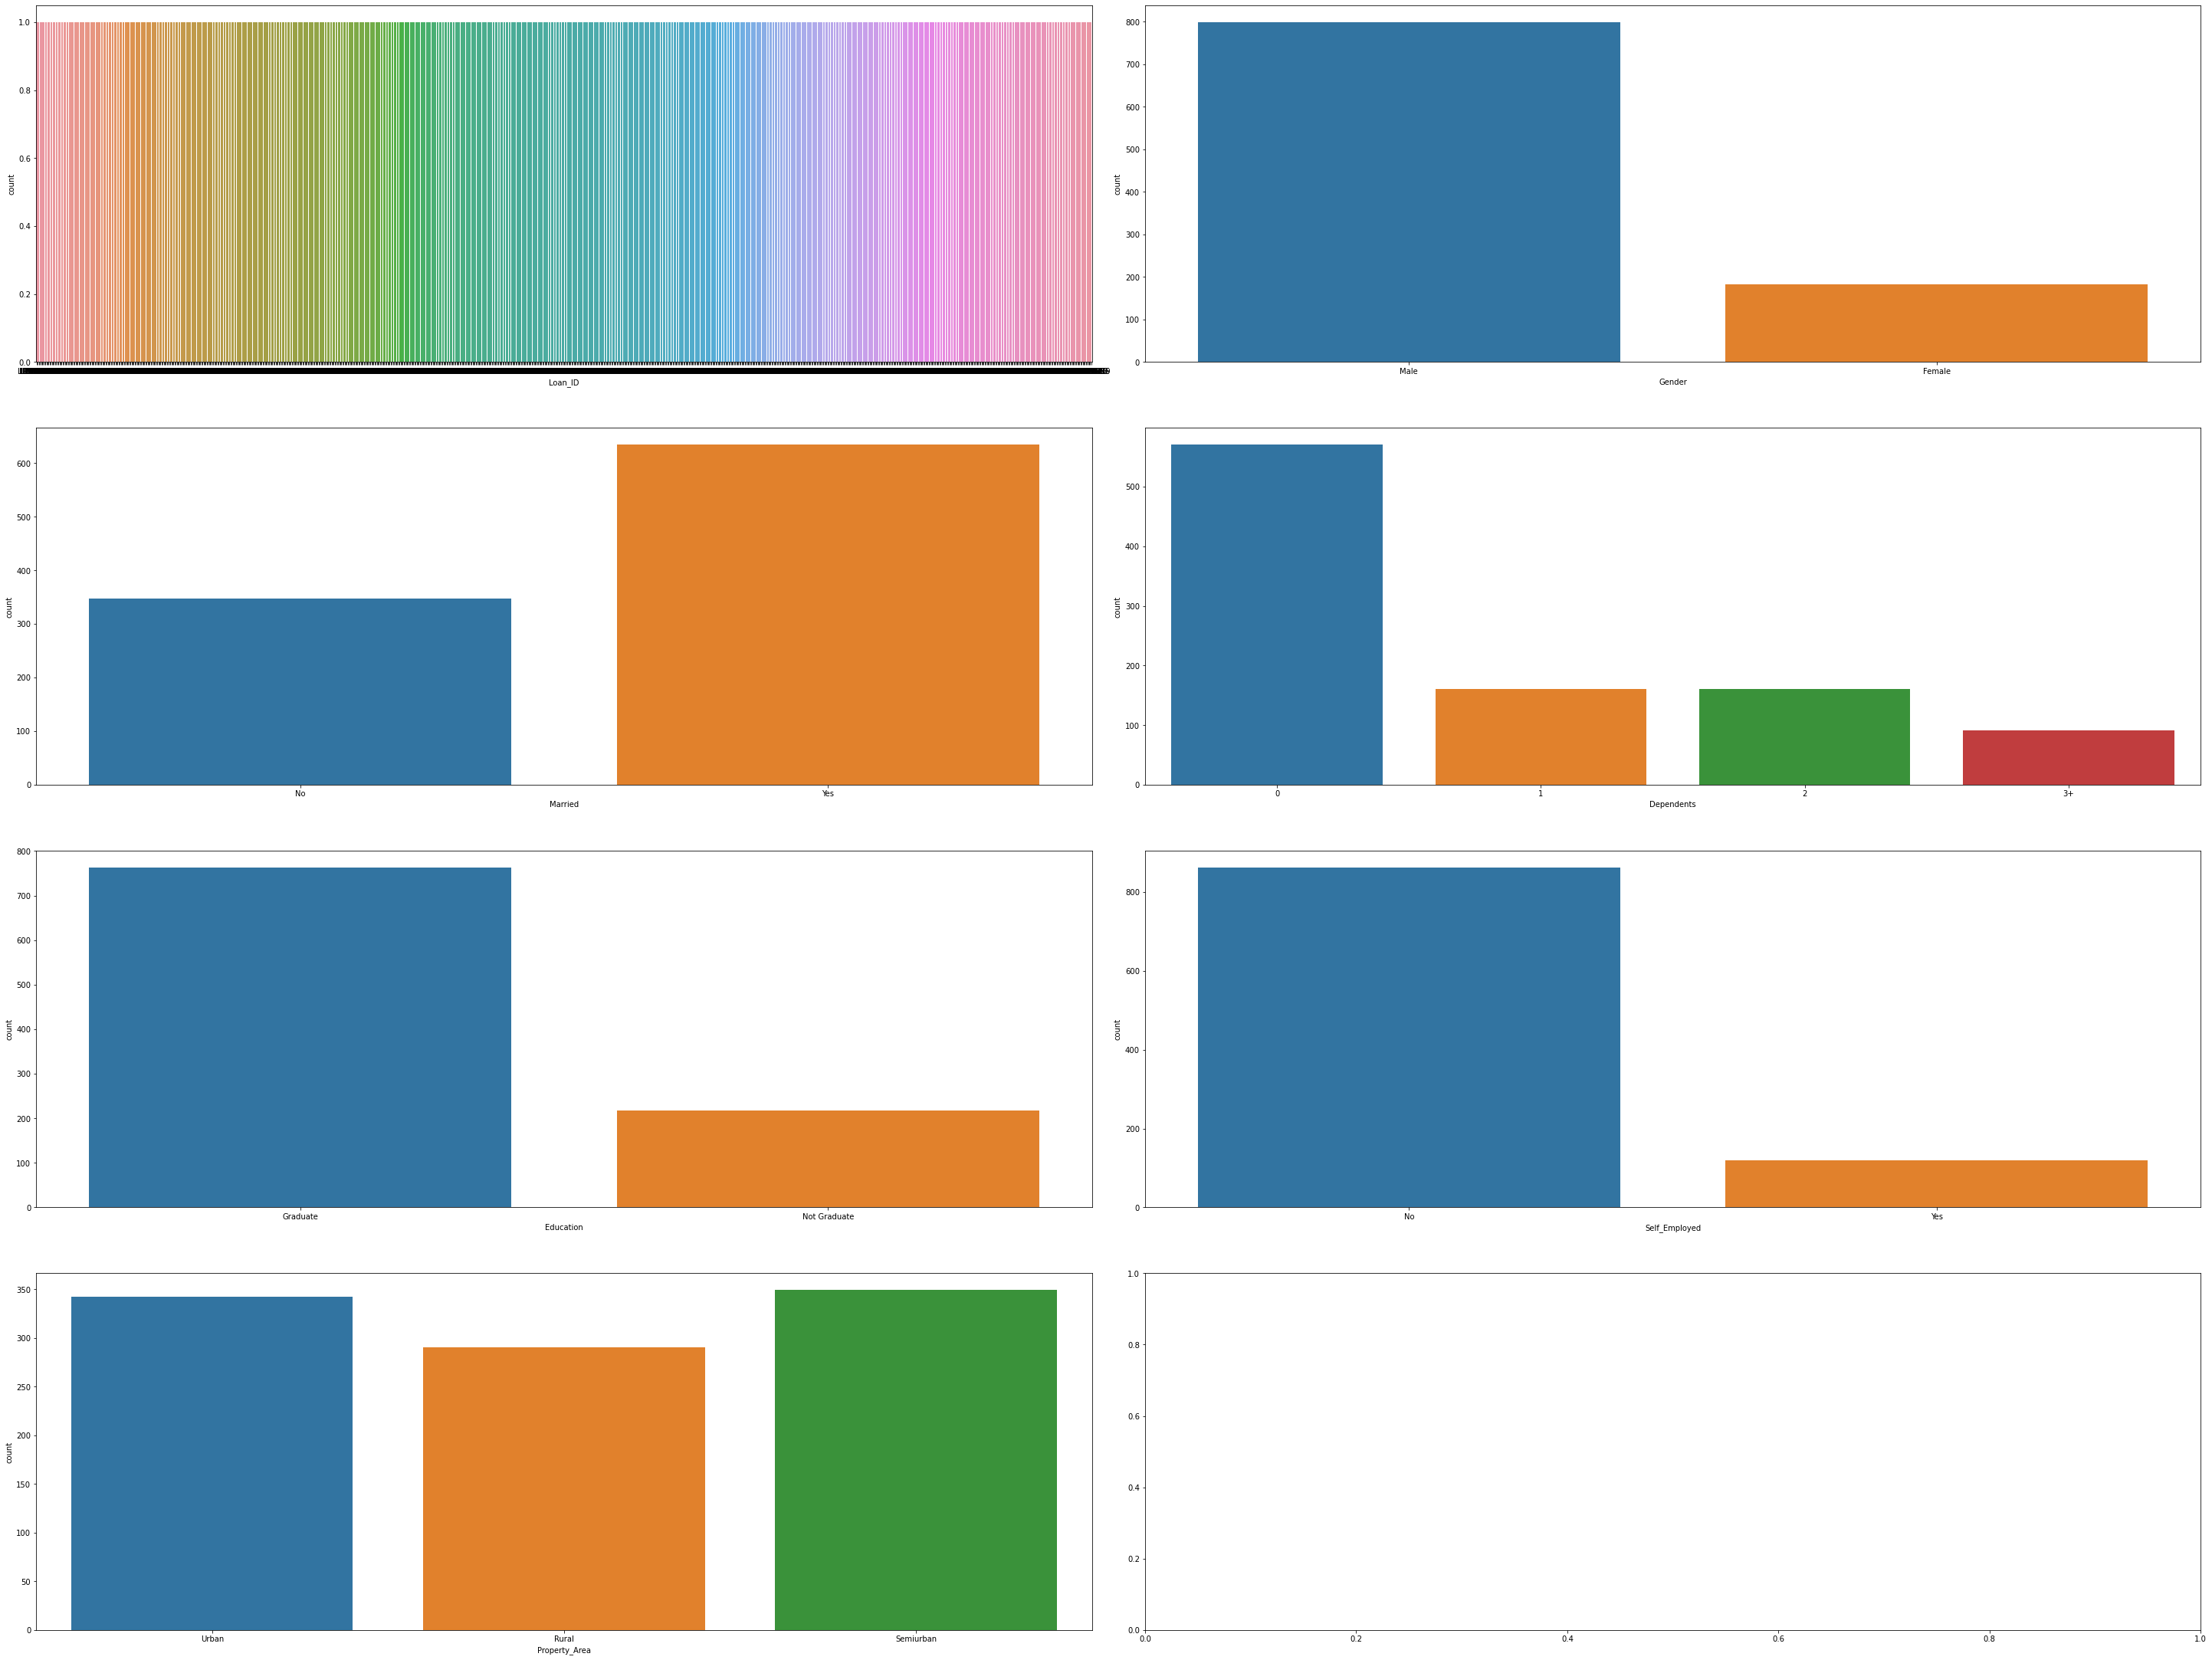

In [26]:
#Variables categóricas
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(40, 30))
axs = axs.flatten() # 

index = 0
for k,v in data[data_cat].items(): 
    sns.countplot(v, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Transformación variables categóricas a numéricas

In [27]:
data["Gender"] = data["Gender"].map( {'Female': 1, 'Male': 0} ).astype(int)
data["Married"] = data["Married"].map({'Yes': 1, 'No': 0} ).astype(int)
data["Dependents"] = data["Dependents"].map({'0': 0, '1': 1, "2": 2, "3+": 3} ).astype(int)
data["Education"] = data["Education"].map( {'Graduate': 1, 'Not Graduate': 0} ).astype(int)
data["Self_Employed"] = data["Self_Employed"].map({'Yes': 1, 'No': 0} ).astype(int)
data["Property_Area"] = data["Property_Area"].map({'Urban': 0, 'Rural': 1, "Semiurban": 2} ).astype(int)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             981 non-null    int32  
 2   Married            981 non-null    int32  
 3   Dependents         981 non-null    int32  
 4   Education          981 non-null    int32  
 5   Self_Employed      981 non-null    int32  
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         981 non-null    float64
 9   Loan_Amount_Term   981 non-null    float64
 10  Credit_History     981 non-null    float64
 11  Property_Area      981 non-null    int32  
dtypes: float64(4), int32(6), int64(1), object(1)
memory usage: 96.6+ KB


<AxesSubplot:>

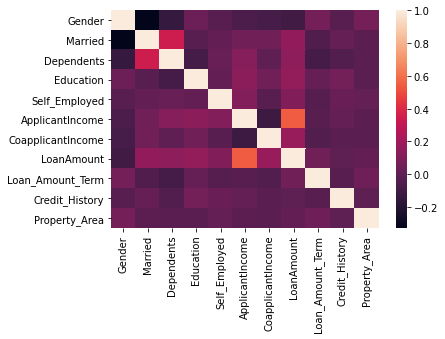

In [29]:
# Correlación entre las variables
sns.heatmap(data.corr())

In [30]:
# La correlación más importante es la que hay entre LoanAmount y ApplicantIncome.
# Aunque no es demasiado destacable.

ApplicantIncome


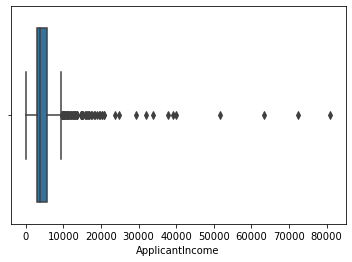

CoapplicantIncome


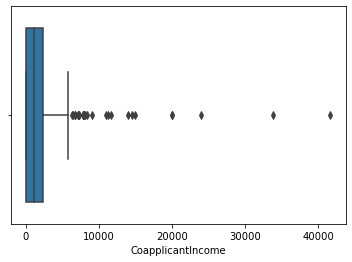

LoanAmount


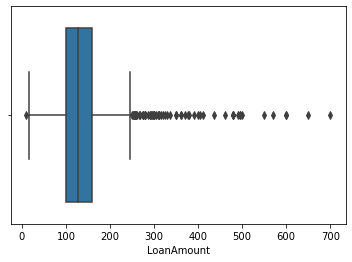

Loan_Amount_Term


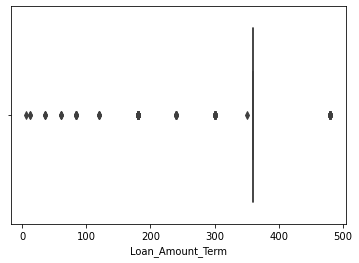

Credit_History


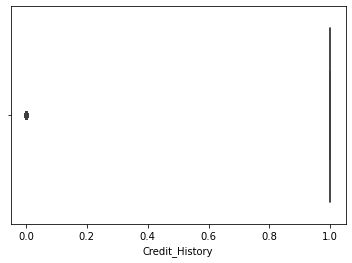

In [31]:
for i in data_num:
    sns.boxplot(x=data[i])
    print(i)
    plt.show()


In [32]:
# Lo que más llama la atención, en cuanto a Outliers, son los relativos a
# ApplicantIncome y CoapplicantIncome.

# Establezco el índice, ya que al hacer el append se añaden las filas, pero
# el índice no es correlativo.
data.index = range(0, 981)

Procedo a localizar las filas que, según el procedimiento del zscore, se desvían 4 veces de la media de la variable. Esas las considero Outliers.

In [33]:
threshold = 4
z = np.abs(stats.zscore(data["ApplicantIncome"]))

print(np.where(z > 4))

(array([155, 171, 183, 185, 333, 409, 443, 695, 757, 893], dtype=int64),)


In [34]:
threshold = 4
z = np.abs(stats.zscore(data["CoapplicantIncome"]))

print(np.where(z > 4))

(array([402, 417, 581, 600, 639, 844, 851, 965], dtype=int64),)


In [35]:
# Elimino filas
data.drop([155, 171, 183, 185, 333, 402, 409, 417, 443, 581, 600, 639, 695, 757, 844, 851, 893, 965], axis=0)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,0,0,0,1,0,5849,0.0,142.51153,360.0,1.0,0
1,LP001003,0,1,1,1,0,4583,1508.0,128.00000,360.0,1.0,1
2,LP001005,0,1,0,1,1,3000,0.0,66.00000,360.0,1.0,0
3,LP001006,0,1,0,0,0,2583,2358.0,120.00000,360.0,1.0,0
4,LP001008,0,0,0,1,0,6000,0.0,141.00000,360.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,0,1,3,0,1,4009,1777.0,113.00000,360.0,1.0,0
977,LP002975,0,1,0,1,0,4158,709.0,115.00000,360.0,1.0,0
978,LP002980,0,0,0,1,0,3250,1993.0,126.00000,360.0,1.0,2
979,LP002986,0,1,0,1,0,5000,2393.0,158.00000,360.0,1.0,1


In [36]:
# Añado la variable objetivo y divido en Train y Test
data.df = data.merge(loan_status, left_on= "Loan_ID", right_on= "Loan_ID", how = "left")

In [37]:
data.df["Loan_Status"].value_counts().sum()

614

In [38]:
df_train = data.df.iloc[0:614]

In [39]:
df_test = data.df.iloc[614:]
df_test.drop("Loan_Status", axis = 1, inplace = True)

In [40]:
 # Establezco Loan_ID como indice, puesto que no aporta al modelo.
df_train.set_index("Loan_ID", inplace = True)
df_test.set_index("Loan_ID", inplace = True)    

In [41]:
# Convierto, para tenerlo todo numérico, la variable objetivo a 0, 1
df_train["Loan_Status"] = df_train["Loan_Status"].map({'Y': 1, 'N': 0} ).astype(int)

### Oversampling

In [42]:
# Cómo podemos ver, los datos iniciales están desbalanceados.
df_train["Loan_Status"].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [43]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


sm = SMOTE()
df_train_res, y_res = sm.fit_resample(X = df_train.drop("Loan_Status", axis = 1), y = df_train.Loan_Status.ravel())

In [44]:
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({1: 422, 0: 422})


### Muestreo de los datos

In [45]:
X_train, X_test, y_train, y_test = train_test_split (df_train_res, 
                                                     y_res,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = y_res)

### Modelos de clasificación

Decission Tree

In [46]:
tree_mod = DecisionTreeClassifier(criterion="gini").fit(X_train, y_train)
tree_pred = tree_mod.predict(X_test)

- AUC: {roc_auc}


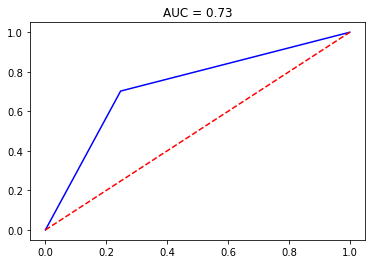

In [47]:
saca_metricas(y_test, tree_pred)

Random Forest

In [48]:
classifier2 = RandomForestClassifier().fit(X_train, y_train)
pred2 = classifier2.predict(X_test)

- AUC: {roc_auc}


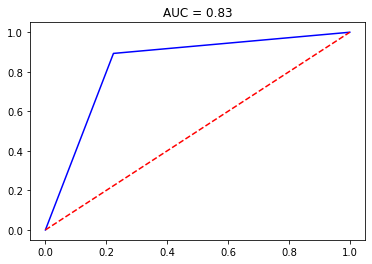

In [49]:
saca_metricas(y_test, pred2)

Linear SVC

In [50]:
classifier3 = LinearSVC(penalty='l1', dual= False).fit(X_train, y_train)
pred3 = classifier3.predict(X_test)

- AUC: {roc_auc}


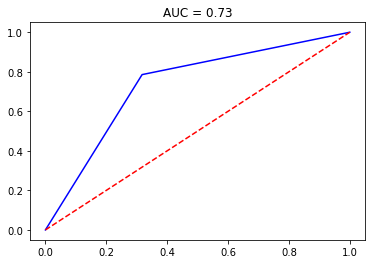

In [51]:
saca_metricas(y_test, pred3)

Logistic Regression

In [52]:
classifier4 = LogisticRegression().fit(X_train, y_train)
pred4 = classifier4.predict(X_test)

- AUC: {roc_auc}


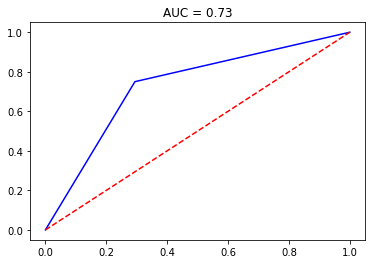

In [53]:
saca_metricas(y_test, pred4)

Para terminar, con el mejor resultado, uso la validación cruzada y saco las medidas de precisión.

In [54]:
cv = cross_val_score(
    classifier2,
    X_train, 
    y_train,
    scoring = "roc_auc",
    cv = 5
)
print(cv)
print("CV ROC:", cv.mean(), np.std(cv))

[0.91714223 0.90386304 0.92087357 0.88114574 0.83318701]
CV ROC: 0.8912423178226515 0.032188381087430704


In [55]:
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        85
           1       0.80      0.89      0.84        84

    accuracy                           0.83       169
   macro avg       0.84      0.83      0.83       169
weighted avg       0.84      0.83      0.83       169



### Importancia de variables

In [56]:
imp = {}
for i in range(len(X_train.columns)):
    imp[X_train.columns[i]] = [classifier2.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
Credit_History,0.291983
ApplicantIncome,0.168452
LoanAmount,0.155336
CoapplicantIncome,0.098301
Property_Area,0.080019
Married,0.051468
Loan_Amount_Term,0.042959
Dependents,0.041710
Education,0.038268
Gender,0.017897


### Predicción

In [57]:
modelo_predict = classifier2.predict(df_test)

In [58]:
modelo_predict

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,

In [59]:
modelo_predict = (pd.DataFrame(modelo_predict,columns=['Loan_Status'],index=df_test.index))

In [60]:
modelo_predict["Loan_Status"] = modelo_predict["Loan_Status"].map({1:'Y', 0:'N'} )
modelo_predict

,Loan_Status
Loan_ID,
LP001015,Y
LP001022,Y
LP001031,Y
LP001035,Y
LP001051,N
...,...
LP002971,Y
LP002975,Y
LP002980,Y


In [61]:
modelo_predict.to_csv("predcit1.csv")